In [1]:
import os
import pandas as pd
import numpy as np
from numpy import nan
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
import scipy.stats
import pymannkendall as mk
from scipy.stats import linregress
import math
from scipy.stats import pearsonr
from numpy import nan

## Data Audit

In [2]:
df_mastertable = pd.read_csv('../data/competitor_kpi.csv')

In [3]:
df_mastertable.head(5)

Vendor       Date  Survey Count  Actual AHT  Resolution Rate  \
0  Atento-Bogotá  6/19/2021           1.0         NaN              NaN   
1  Atento-Bogotá  6/21/2021           1.0         NaN              NaN   
2  Atento-Bogotá   7/1/2021           2.0         NaN              NaN   
3  Atento-Bogotá   7/2/2021           7.0         NaN            0.286   
4  Atento-Bogotá   7/3/2021           6.0         NaN            0.667   

   Resolution Rate No  Adjusted AHT    AHS  C2E Rate    CES  ...  \
0               1.000           NaN  0.000       NaN  0.000  ...   
1               1.000           NaN  1.000       NaN  1.000  ...   
2               1.000           NaN  0.500       NaN  1.000  ...   
3               0.714           NaN  0.571       NaN  0.571  ...   
4               0.333           NaN  0.667       NaN  0.667  ...   

   OBC Resolution Rate  OBC Survey Response Rate  OSL Count  OSL NE Count  \
0                  NaN                       NaN        NaN           NaN   
1                  NaN                       NaN        NaN           NaN   
2                  NaN                       NaN        NaN           NaN   
3                  0.0                       NaN        NaN           NaN   
4                  NaN                       NaN        NaN           NaN   

   ResRec Hours  ResRec SLA  Survey Response Rate  TRT Escalated Hrs  TRT Hrs  \
0           NaN         NaN                   NaN                NaN      NaN   
1           NaN         NaN                   NaN                NaN      NaN   
2           NaN         NaN                   NaN                NaN      NaN   
3           NaN         NaN                   NaN                NaN      NaN   
4           NaN         NaN                   NaN                NaN      NaN   

   TRT SLA  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  

[5 rows x 36 columns]

In [4]:
df_mastertable.shape

(5273, 36)

In [5]:
null_percentage = pd.DataFrame(
    (100 * df_mastertable.isna().sum() / df_mastertable.shape[0]).sort_values(ascending=False),
     columns=['Percentage'])

display(null_percentage)
num_null = len(null_percentage[null_percentage.Percentage != 0])
print(f'Number of features with null values: {num_null}')

Percentage
IRT Email (avg. sec)       37.910108
IRT Email (avg. hrs)       37.910108
Email SLA                  37.910108
ResRec Hours               37.473924
ResRec SLA                 37.398066
NE C2P Rate                36.980846
Chat SLA                   36.980846
IRT Chat (avg. sec)        36.980846
OB Connected vs Dialed     36.980846
Concurrency                36.980846
Adjusted AHT               36.980846
Actual AHT                 36.980846
NE C2E Rate                36.942917
OSL NE Count               36.829130
NETRT Hrs                  36.829130
NETRT SLA                  36.829130
Survey Response Rate       36.791200
OBC Survey Response Rate   36.791200
OSL Count                  36.753271
TRT Escalated Hrs          36.753271
TRT Hrs                    36.753271
OBC Rate                   36.753271
TRT SLA                    36.753271
Escalation Rate            36.753271
C2E Rate                   36.753271
OBC Resolution Rate         5.196283
CES                         2.180922
AHS                         2.180922
Resolution Rate             0.644794
Resolution Rate No          0.474113
Non OBC RR                  0.189645
Non OBC RR Yes              0.094823
Non OBC Survey Count        0.056894
Survey Count                0.056894
Date                        0.000000
Vendor                      0.000000

Number of features with null values: 34


In [6]:
dup = df_mastertable.shape[0] - df_mastertable.drop_duplicates().shape[0]
print(f'There are {dup} duplicate rows')

There are 0 duplicate rows


In [7]:
df_mastertable.columns

Index(['Vendor', 'Date', 'Survey Count', 'Actual AHT', 'Resolution Rate',
       'Resolution Rate No', 'Adjusted AHT', 'AHS', 'C2E Rate', 'CES',
       'Chat SLA', 'Concurrency', 'Email SLA', 'Escalation Rate',
       'IRT Chat (avg. sec)', 'IRT Email (avg. hrs)', 'IRT Email (avg. sec)',
       'NE C2E Rate', 'NE C2P Rate', 'NETRT Hrs', 'NETRT SLA', 'Non OBC RR',
       'Non OBC RR Yes', 'Non OBC Survey Count', 'OB Connected vs Dialed',
       'OBC Rate', 'OBC Resolution Rate', 'OBC Survey Response Rate',
       'OSL Count', 'OSL NE Count', 'ResRec Hours', 'ResRec SLA',
       'Survey Response Rate', 'TRT Escalated Hrs', 'TRT Hrs', 'TRT SLA'],
      dtype='object')

In [8]:
df_surveycount = pd.read_csv('../data/competitor_survey.csv')

In [9]:
df_surveycount.head(5)

Vendor       Date Market  Survey Count  Survey Response Rate
0  Atento-Bogotá  6/19/2021   APAC             1                   NaN
1  Atento-Bogotá  6/21/2021   APAC             1                   NaN
2  Atento-Bogotá   7/1/2021   APAC             2                   NaN
3  Atento-Bogotá   7/2/2021   APAC             1                   NaN
4  Atento-Bogotá   7/2/2021   EMEA             5                   NaN

In [10]:
df_surveycount.shape

(19716, 5)

In [11]:
null_percentage = pd.DataFrame(
    (100 * df_surveycount.isna().sum() / df_surveycount.shape[0]).sort_values(ascending=False),
     columns=['Percentage'])

display(null_percentage)
num_null = len(null_percentage[null_percentage.Percentage != 0])
print(f'Number of features with null values: {num_null}')

Percentage
Survey Response Rate   36.234530
Market                  2.292554
Vendor                  0.000000
Date                    0.000000
Survey Count            0.000000

Number of features with null values: 2


In [12]:
df_surveycount.columns

Index(['Vendor', 'Date', 'Market', 'Survey Count', 'Survey Response Rate'], dtype='object')

## Data Clean

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Mastertable

In [14]:
df_mastertable['Date'] = pd.to_datetime(df_mastertable['Date'])

In [15]:
df_mastertable['Month'] = pd.PeriodIndex(df_mastertable.Date, freq='M')

In [16]:
df_mastertable['Quarter'] = pd.PeriodIndex(df_mastertable.Date, freq='Q')

In [17]:
df_scaled = df_mastertable[(df_mastertable['Date'] >= "2022-01-01") &
                           (df_mastertable['Date'] <= "2023-03-31")][['Vendor', 'Date', 'Month', 'Quarter',
                                                                    'Resolution Rate', 'AHS',
                                                                    'Actual AHT', 'NETRT SLA', 'ResRec SLA',
                                                                    'Email SLA', 'Chat SLA']]

In [18]:
df_scaled = df_scaled.groupby(['Vendor', 'Month']).aggregate(
Resolution_Rate = ('Resolution Rate', 'mean'),
AHS = ('AHS', 'mean'),
AHT = ('Actual AHT', 'mean'),
NETRT = ('NETRT SLA', 'mean'),
ResRec = ('ResRec SLA', 'mean'),
Email = ('Email SLA', 'mean'),
Chat = ('Chat SLA', 'mean')).reset_index()

In [19]:
df_scaled.rename(columns = {'Resolution_Rate':'Resolution Rate',
                            'AHT':'Actual AHT',
                            'NETRT':'NETRT SLA',
                            'ResRec':'ResRec SLA',
                            'Email':'Email SLA',
                            'Chat':'Chat SLA',}, inplace = True)

In [20]:
normalize_higher = ['Resolution Rate', 'AHS', 'NETRT SLA', 'ResRec SLA', 'Email SLA', 'Chat SLA']

In [21]:
normalize_lower = ['Actual AHT']

In [22]:
for column in df_scaled[df_scaled.columns.intersection(normalize_higher)].columns:
    df_scaled[column] = (df_scaled[column] - df_scaled[column].min()) / (df_scaled[column].max() - df_scaled[column].min())

In [23]:
for column in df_scaled[df_scaled.columns.intersection(normalize_lower)].columns:
    df_scaled[column] = (df_scaled[column].max() - df_scaled[column]) / (df_scaled[column].max() - df_scaled[column].min())

In [24]:
df_scaled.head(5)

Vendor    Month  Resolution Rate   AHS  Actual AHT  NETRT SLA  \
0  Atento-Bogotá  2022-01            0.820 0.708       0.898      0.472   
1  Atento-Bogotá  2022-02            0.523 0.402       0.809      0.476   
2  Atento-Bogotá  2022-03            0.867 0.715       0.775      0.414   
3  Atento-Bogotá  2022-04            0.787 0.788       0.740      0.757   
4  Atento-Bogotá  2022-05            0.612 0.636       0.647      0.817   

   ResRec SLA  Email SLA  Chat SLA  
0       0.651      0.583     0.152  
1       0.622      0.684     0.303  
2       0.637      0.681     0.424  
3       0.764      0.651     0.270  
4       0.741      0.634     0.351

In [25]:
effectiveness = ['Resolution Rate', 'AHS']

In [26]:
efficiency = ['Actual AHT', 'NETRT SLA', 'ResRec SLA']

In [27]:
speed = ['Email SLA', 'Chat SLA']

In [28]:
df_scaled['effectiveness'] = df_scaled[effectiveness].mean(axis=1)

In [29]:
df_scaled['efficiency'] = df_scaled[efficiency].mean(axis=1)

In [30]:
df_scaled['speed'] = df_scaled[speed].mean(axis=1)

Survey Count

In [31]:
df_surveycount['Date'] = pd.to_datetime(df_surveycount['Date'])

In [32]:
df_surveycount['Month'] = pd.PeriodIndex(df_surveycount.Date, freq='M')

## Descriptive Analysis (Market Share)

In [33]:
colors = {'Atento-Bogotá':'#808000', 'Concentrix-Berlin':'#ff0000', 
          'Concentrix-Gurgaon':'#c71585', 'Concentrix-Kuala Lumpur':'#00ff00',
          'Concentrix-Porto, Portugal':'#00ffff', 'Teledirect-Manila':'orange', 
          'Teleperformance-Lisbon':'#1e90ff'}

In [34]:
df_line = df_surveycount[(df_surveycount['Date'] >= "2022-01-01") &
                         (df_surveycount['Date'] <= "2023-03-31")].groupby(['Vendor', 'Month']).aggregate(
survey = ('Survey Count', 'sum')).reset_index()

In [35]:
df_line['Month'] = df_line['Month'].astype(str)

In [36]:
fig, ax = plt.subplots(figsize=(10, 7))

grouped = df_line.groupby('Vendor')
for key, group in grouped:
    group.plot(ax=ax, kind='line',
               x='Month', y='survey', lw=3,
               label=key, color=colors[key])
    
plt.xlabel('Month - Year', fontweight='bold')
plt.ylabel('Monthly Survey Count', fontweight='bold')
plt.title('Vendor Survey Count', fontweight='bold')
plt.legend(fontsize="8", loc ="upper left")
plt.show()

In [37]:
df_surveyshare = pd.pivot(df_line, index=['Vendor'], columns = 'Month', values = 'survey').reset_index()

In [38]:
df_surveyshare['Total Survey'] = df_surveyshare.iloc[:, 1:17].sum(axis=1)

In [39]:
df_surveyshare['CMGR (%)'] = ((df_surveyshare['2023-03']/df_surveyshare['2022-01'])**(1/14)-1) * 100

In [40]:
df_surveyshare['Latest Growth Rate (%)'] = ((df_surveyshare['2023-03']/df_surveyshare['2023-02'])-1) * 100

In [41]:
df_surveyshare = pd.merge(df_surveyshare,
                          df_surveycount.groupby('Vendor').aggregate(
                              ResponseRate = ('Survey Response Rate', 'mean')).reset_index(),
                          on = ['Vendor'], how = 'left')

In [42]:
df_surveyshare['Ticket Count'] = np.round(df_surveyshare['Total Survey'] / df_surveyshare['ResponseRate'], 4)

In [43]:
df_surveyshare.sort_values(['Total Survey'], ascending=False)

Vendor  2022-01  2022-02  2022-03  2022-04  2022-05  \
5           Teledirect-Manila    17393    15017    16334    15082    15399   
2          Concentrix-Gurgaon     9018     7844     9106     7554    10028   
6      Teleperformance-Lisbon     4928     4973     6461     5702     6681   
3     Concentrix-Kuala Lumpur     5882     5642     5946     5779     6988   
1           Concentrix-Berlin     1496     1383     1479     1161     1179   
0               Atento-Bogotá      488      590     1223     1452     2067   
4  Concentrix-Porto, Portugal      657      497      564      447      564   

   2022-06  2022-07  2022-08  2022-09  ...  2022-11  2022-12  2023-01  \
5    16067    18050    18817    19984  ...    11999    15158    20062   
2    11206    13384    11043    10845  ...     8910     8225     8640   
6     5934     7472     6916     8010  ...     7318     6843     6755   
3     7712     7974     7914     8329  ...     4780     4462     4451   
1      992     1018      925      860  ...     1484     1406     1833   
0     2369     1448      909     1598  ...     1643     1917     1801   
4      468      487      396      522  ...      434      462      479   

   2023-02  2023-03  Total Survey  CMGR (%)  Latest Growth Rate (%)  \
5    21797    25986        261410     2.909                  19.218   
2     9010    12428        146026     2.317                  37.936   
6     6545     7611         98788     3.153                  16.287   
3     4295     6230         91623     0.411                  45.052   
1     1668     2098         20666     2.445                  25.779   
0     1145      674         20439     2.333                 -41.135   
4      528      570          7398    -1.009                   7.955   

   ResponseRate  Ticket Count  
5         0.048   5423178.530  
2         0.061   2380548.355  
6         0.055   1798512.242  
3         0.060   1532847.117  
1         0.067    309766.605  
0         0.047    434853.640  
4         0.073    101712.002  

[7 rows x 21 columns]

In [44]:
df_surveyshare = pd.pivot(df_line, index=['Month'], columns = 'Vendor', values = 'survey').reset_index()

In [45]:
df_surveyshare['Total Survey'] = df_surveyshare.iloc[:, 1:8].sum(axis=1)

In [46]:
df_surveyshare.iloc[:, 1:8] = df_surveyshare.iloc[:, 1:8].div(df_surveyshare['Total Survey'], axis=0)

In [47]:
df_surveyshare

Vendor    Month  Atento-Bogotá  Concentrix-Berlin  Concentrix-Gurgaon  \
0       2022-01          0.012              0.038               0.226   
1       2022-02          0.016              0.038               0.218   
2       2022-03          0.030              0.036               0.221   
3       2022-04          0.039              0.031               0.203   
4       2022-05          0.048              0.027               0.234   
5       2022-06          0.053              0.022               0.250   
6       2022-07          0.029              0.020               0.269   
7       2022-08          0.019              0.020               0.235   
8       2022-09          0.032              0.017               0.216   
9       2022-10          0.029              0.044               0.231   
10      2022-11          0.045              0.041               0.244   
11      2022-12          0.050              0.037               0.214   
12      2023-01          0.041              0.042               0.196   
13      2023-02          0.025              0.037               0.200   
14      2023-03          0.012              0.038               0.224   

Vendor  Concentrix-Kuala Lumpur  Concentrix-Porto, Portugal  \
0                         0.148                       0.016   
1                         0.157                       0.014   
2                         0.145                       0.014   
3                         0.155                       0.012   
4                         0.163                       0.013   
5                         0.172                       0.010   
6                         0.160                       0.010   
7                         0.169                       0.008   
8                         0.166                       0.010   
9                         0.138                       0.008   
10                        0.131                       0.012   
11                        0.116                       0.012   
12                        0.101                       0.011   
13                        0.095                       0.012   
14                        0.112                       0.010   

Vendor  Teledirect-Manila  Teleperformance-Lisbon  Total Survey  
0                   0.436                   0.124         39862  
1                   0.418                   0.138         35946  
2                   0.397                   0.157         41113  
3                   0.406                   0.153         37177  
4                   0.359                   0.156         42906  
5                   0.359                   0.133         44748  
6                   0.362                   0.150         49833  
7                   0.401                   0.147         46920  
8                   0.399                   0.160         50148  
9                   0.375                   0.174         38050  
10                  0.328                   0.200         36568  
11                  0.394                   0.178         38473  
12                  0.456                   0.153         44021  
13                  0.485                   0.145         44988  
14                  0.467                   0.137         55597

In [48]:
# 15-month CMGR of TDCX in Survey Share

((df_surveyshare.iloc[14, 6]/df_surveyshare.iloc[0, 6])**(1/14)-1) * 100

0.4925257344081668

In [49]:
(df_surveyshare.iloc[14, 6] - df_surveyshare.iloc[0, 6]) * 100

3.1068980435332074

In [50]:
# Latest growth rate of TDCX in Survey Share

((df_surveyshare.iloc[14, 6]/df_surveyshare.iloc[13, 6])-1) * 100

-3.5309418131728387

In [51]:
(df_surveyshare.iloc[14, 6] - df_surveyshare.iloc[13, 6]) * 100

-1.7107659531814812

In [52]:
df_surveyshare.iloc[14, 6]

0.46739932010720003

In [53]:
Month = df_surveyshare['Month'].values
Share = np.round(df_surveyshare['Teledirect-Manila'].values, 2)

# Create Tick Locations
x = np.arange(len(Month))
# Plotting
fig, ax = plt.subplots(figsize=(20, 7))
# Do not offset the values of x to center labels (default)
ax.bar(x, Share, width=.6, color="orange")

# Labels, ticks, etc.
plt.yticks(np.arange(0, 0.7, step=0.1))
ax.set_ylabel('Survey Share', fontweight='bold')
ax.set_xlabel('Month - Year', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(Month)

# Add Bar Labels
for c in ax.containers:
    ax.bar_label(c, fontsize=20)

plt.show()

In [54]:
df_metric = df_scaled.groupby(['Vendor']).aggregate(
Resolution_Rate = ('Resolution Rate', 'mean'),
AHS = ('AHS', 'mean'),
AHT = ('Actual AHT', 'mean'),
NETRT = ('NETRT SLA', 'mean'),
ResRec = ('ResRec SLA', 'mean'),
Email = ('Email SLA', 'mean'),
Chat = ('Chat SLA', 'mean'),
effectiveness = ('effectiveness', 'mean'),
efficiency = ('efficiency', 'mean'),
speed = ('speed', 'mean')).reset_index()

In [55]:
df_metric.rename(columns = {'Resolution_Rate':'Resolution Rate',
                            'AHT':'Actual AHT',
                            'NETRT':'NETRT SLA',
                            'ResRec':'ResRec SLA',
                            'Email':'Email SLA',
                            'Chat':'Chat SLA',}, inplace = True)

In [56]:
df_metric['overall'] = df_metric[['effectiveness', 'efficiency', 'speed']].mean(axis=1)

In [57]:
df_metric.sort_values(['overall'], ascending=False)

Vendor  Resolution Rate   AHS  Actual AHT  NETRT SLA  \
4  Concentrix-Porto, Portugal            0.675 0.770       0.748      0.705   
3     Concentrix-Kuala Lumpur            0.805 0.754       0.707      0.561   
6      Teleperformance-Lisbon            0.801 0.828       0.806      0.726   
2          Concentrix-Gurgaon            0.723 0.746       0.786      0.593   
1           Concentrix-Berlin            0.719 0.803       0.535      0.693   
5           Teledirect-Manila            0.700 0.722       0.861      0.651   
0               Atento-Bogotá            0.391 0.385       0.572      0.403   

   ResRec SLA  Email SLA  Chat SLA  effectiveness  efficiency  speed  overall  
4       0.764      0.765     0.652          0.723       0.739  0.709    0.723  
3       0.770      0.783     0.601          0.779       0.679  0.692    0.717  
6       0.797      0.647     0.444          0.815       0.776  0.546    0.712  
2       0.753      0.708     0.563          0.735       0.711  0.636    0.694  
1       0.661      0.721     0.589          0.761       0.629  0.655    0.682  
5       0.447      0.718     0.547          0.711       0.653  0.633    0.666  
0       0.475      0.602     0.437          0.388       0.483  0.519    0.464

## Descriptive Analysis (Radar Chart)

In [58]:
angles = np.linspace(0, 2*np.pi, 7, endpoint = False)
angles = np.concatenate((angles, [angles[0]]))

In [59]:
kpi = df_metric.drop(['Vendor', 'effectiveness', 'efficiency', 'speed', 'overall'], axis = 1).columns
kpi = np.concatenate((kpi, [kpi[0]]))

In [60]:
vendors = df_metric['Vendor'].unique()

In [61]:
vendor_color = {'Vendor': vendors,
                'Color': ['#808000', '#ff0000', '#c71585', '#00ff00', '#00ffff', 'orange', '#1e90ff']}
vendor_color = pd.DataFrame(vendor_color)

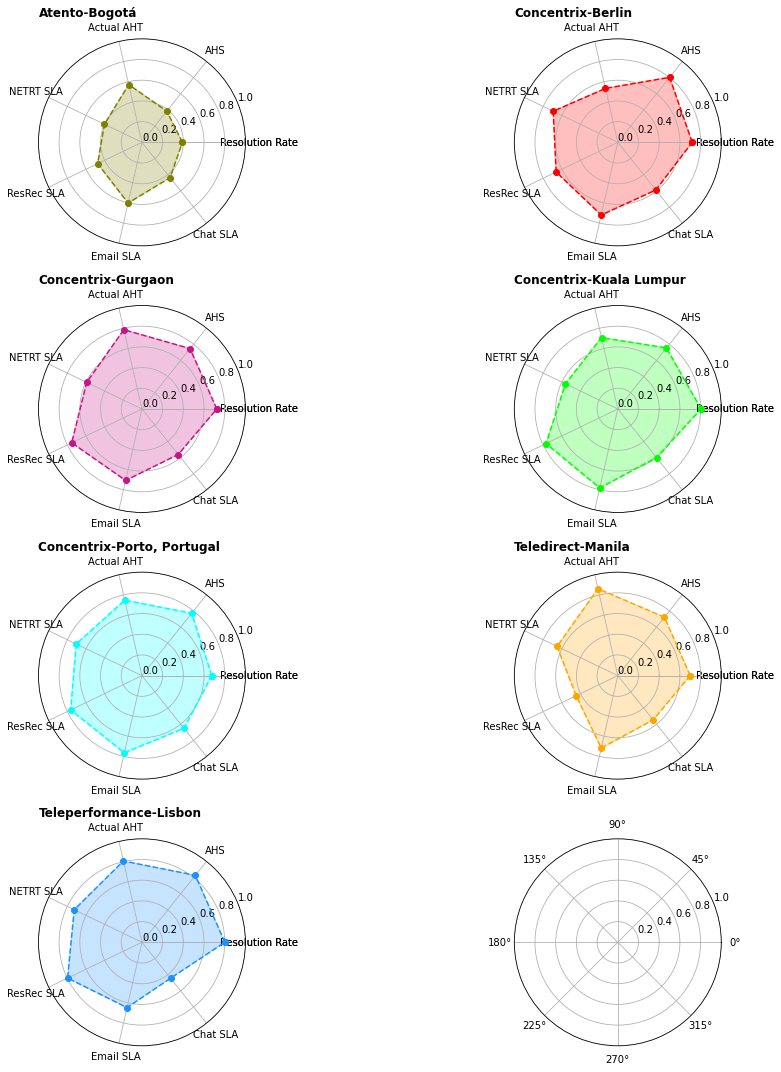

In [62]:
i,j = 0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(len(vendors)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 15),
                        subplot_kw={'projection': 'polar'})

for x in range(len(vendors)):
    
    vendor_interest = vendors[x]
    color = vendor_color.loc[vendor_color['Vendor'] == vendor_interest, 'Color'].iloc[0]
    df_interest = df_metric[df_metric['Vendor'] == vendor_interest]
    vendor_values = df_interest.drop(['Vendor', 'effectiveness', 'efficiency', 'speed', 'overall'], axis = 1).iloc[0].values
    vendor_values = np.append(vendor_values, vendor_values[0])
    
    axs[i][j].plot(angles, vendor_values, 'o--', color = color)
    axs[i][j].fill(angles, vendor_values, alpha = 0.25, color = color)
    axs[i][j].set_thetagrids(angles * 180/np.pi, kpi)
    axs[i][j].set_ylim(0,1)
    axs[i][j].set_yticks(np.arange(0,1.2,0.2))
    axs[i][j].set_title(label = vendor_interest, fontweight = "bold", loc = "left", color = "black")

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0

plt.grid(True)
plt.tight_layout()
plt.show()

## Descriptive Analysis (Performance & Survey Share Position)

In [63]:
df_scaled['overall'] = df_scaled[['effectiveness', 'efficiency', 'speed']].mean(axis=1)

In [64]:
df_scaled['Month'] = df_scaled['Month'].astype(str)

In [65]:
df_surveyshare = pd.melt(df_surveyshare, id_vars='Month', value_vars=['Atento-Bogotá', 'Concentrix-Berlin', 'Concentrix-Gurgaon',
                                                                      'Concentrix-Kuala Lumpur', 'Concentrix-Porto, Portugal',
                                                                      'Teledirect-Manila', 'Teleperformance-Lisbon'], value_name='SurveyShare')

In [66]:
df_survey_performance = pd.merge(df_scaled[['Vendor', 'Month', 'overall']],
                                 df_surveyshare[['Vendor', 'Month', 'SurveyShare']],
                                 on = ['Vendor', 'Month'], how = 'left')

In [67]:
fig, ax = plt.subplots(figsize=(10, 7))

grouped = df_survey_performance.groupby('Vendor')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter',
               edgecolors='black', s=100,
               x='overall', y='SurveyShare', 
               label=key, color=colors[key])
    
    group.plot(ax=ax, kind='line',
               x='overall', y='SurveyShare',
               label='_nolegend_', color=colors[key])
    
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Overall Performance Score', fontweight='bold')
plt.yticks(np.arange(0, 0.7, step=0.1))
plt.ylabel('Monthly Survey Share', fontweight='bold')
plt.show()

C:\Users\jmbatula\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020C7D1C5310> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\jmbatula\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020C7D1E0E50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\jmbatula\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000020C7D224190> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\jmbatula\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The

## Descriptive Analysis (Resolution Rate Trend)

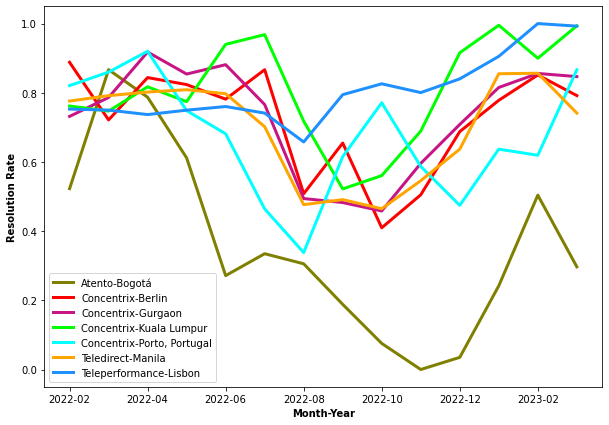

In [68]:
fig, ax = plt.subplots(figsize=(10, 7))

grouped = df_scaled[(df_scaled['Month'] >= "2022-01-01") &
                    (df_scaled['Month'] <= "2023-03-31")].groupby('Vendor')
for key, group in grouped:
    group.plot(ax=ax, kind='line',
               x='Month', y='Resolution Rate',
               lw=3, label=key, color=colors[key])
    
plt.xlabel('Month-Year', fontweight='bold')
plt.ylabel('Resolution Rate', fontweight='bold')
plt.show()

## Trend

In [69]:
df_trend = df_scaled

In [70]:
vendors = df_trend['Vendor'].unique()

In [71]:
kpi = df_trend.drop(['Vendor', 'Month'], axis = 1).columns

In [72]:
df_trend['Vendor'].unique()

array(['Atento-Bogotá', 'Concentrix-Berlin', 'Concentrix-Gurgaon',
       'Concentrix-Kuala Lumpur', 'Concentrix-Porto, Portugal',
       'Teledirect-Manila', 'Teleperformance-Lisbon'], dtype=object)

In [73]:
kpi_trend = pd.DataFrame(columns = ['Vendor', 'Metric', 'Trend', 'Statistic', 'pvalue', 'slope'])

In [74]:
for i in range(len(vendors)):
    for j in range(len(kpi)):
    
        vendor_interest =  vendors[i]
        kpi_interest = kpi[j]
        df_interest = df_trend[df_trend['Vendor'] == vendor_interest].reset_index()[['Month', kpi_interest]]
        
        mk_test = mk.original_test(df_interest[kpi_interest])
        trend = mk_test.trend
        zstatistic = mk_test.z
        pvalue = mk_test.p
        slope = linregress(df_interest.index, df_interest[kpi_interest]).slope
        
        kpi_trend.loc[len(kpi_trend.index)] = [vendor_interest, kpi_interest, trend, zstatistic, pvalue, slope]

In [75]:
kpi_trend

Vendor           Metric       Trend  Statistic  pvalue  \
0            Atento-Bogotá  Resolution Rate  decreasing     -2.672   0.008   
1            Atento-Bogotá              AHS  decreasing     -2.474   0.013   
2            Atento-Bogotá       Actual AHT    no trend     -1.782   0.075   
3            Atento-Bogotá        NETRT SLA  decreasing     -2.672   0.008   
4            Atento-Bogotá       ResRec SLA  decreasing     -2.276   0.023   
..                     ...              ...         ...        ...     ...   
72  Teleperformance-Lisbon         Chat SLA  increasing      2.474   0.013   
73  Teleperformance-Lisbon    effectiveness  increasing      3.365   0.001   
74  Teleperformance-Lisbon       efficiency    no trend     -0.099   0.921   
75  Teleperformance-Lisbon            speed    no trend      1.683   0.092   
76  Teleperformance-Lisbon          overall    no trend      1.584   0.113   

    slope  
0  -0.044  
1  -0.038  
2  -0.021  
3  -0.037  
4  -0.035  
..    ...  
72  0.042  
73  0.014  
74 -0.002  
75  0.021  
76  0.011  

[77 rows x 6 columns]

In [76]:
i,j = 0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(len(vendors)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(30, 20))

for x in range(len(vendors)):
    
    vendor_interest = vendors[x]
    df_interest = df_trend[df_trend['Vendor'] == vendor_interest]
    
    axs[i][j].plot(df_interest['Month'], df_interest['Resolution Rate'], '#191970', linewidth = 2, label = "Resolution Rate")
    axs[i][j].plot(df_interest['Month'], df_interest['AHS'], '#556b2f', linewidth = 2, label = "AHS")
    axs[i][j].plot(df_interest['Month'], df_interest['Actual AHT'], '#00bfff', linewidth = 2, label = "Actual AHT")
    axs[i][j].plot(df_interest['Month'], df_interest['NETRT SLA'], '#ff4500', linewidth = 2, label = "NETRT SLA")
    axs[i][j].plot(df_interest['Month'], df_interest['ResRec SLA'], '#0000ff', linewidth = 2, label = "ResRec SLA")
    axs[i][j].plot(df_interest['Month'], df_interest['Email SLA'], '#ffd700', linewidth = 2, label = "Email SLA")
    axs[i][j].plot(df_interest['Month'], df_interest['Chat SLA'], '#ff1493', linewidth = 2, label = "Chat SLA")
    
    axs[i][j].set_yticks(np.arange(0, 1.2, 0.2), minor=False)
    axs[i][j].set_title(label = vendor_interest, fontweight = "bold", loc = "left", color = "black")
    axs[i][j].legend(loc = "upper right")
    
    
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0

plt.tight_layout()        
plt.show()

# Metric Correlation

* All Vendors

In [77]:
df_corr = df_mastertable[['Resolution Rate', 'AHS', 'Actual AHT', 'NETRT SLA', 'ResRec SLA', 'Email SLA', 'Chat SLA']]

In [78]:
df_pearson = df_corr.corr()

In [79]:
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

In [80]:
df_pvalue = calculate_pvalues(df_corr)

In [81]:
df_pearson[df_pvalue > 0.05] = nan

In [82]:
df_pearson

Resolution Rate    AHS  Actual AHT  NETRT SLA  ResRec SLA  \
Resolution Rate            1.000  0.757      -0.211      0.348       0.277   
AHS                        0.757  1.000      -0.163      0.419       0.264   
Actual AHT                -0.211 -0.163       1.000     -0.087      -0.181   
NETRT SLA                  0.348  0.419      -0.087      1.000       0.315   
ResRec SLA                 0.277  0.264      -0.181      0.315       1.000   
Email SLA                  0.170  0.169      -0.063      0.229       0.206   
Chat SLA                   0.175  0.153         NaN      0.143         NaN   

                 Email SLA  Chat SLA  
Resolution Rate      0.170     0.175  
AHS                  0.169     0.153  
Actual AHT          -0.063       NaN  
NETRT SLA            0.229     0.143  
ResRec SLA           0.206       NaN  
Email SLA            1.000     0.202  
Chat SLA             0.202     1.000

In [83]:
df_corr = df_mastertable.drop(['Vendor', 'Date', 'Month', 'Quarter'], axis = 1) 

In [84]:
df_pearson = df_corr.corr()

In [85]:
df_pvalue = calculate_pvalues(df_corr)

In [86]:
df_pearson[df_pvalue > 0.05] = nan

In [87]:
df_pearson.sort_values(['Resolution Rate'], ascending=False)

Survey Count  Actual AHT  Resolution Rate  \
Resolution Rate                  0.028      -0.211            1.000   
Non OBC RR                       0.086      -0.173            0.804   
AHS                              0.067      -0.163            0.757   
CES                              0.050      -0.236            0.741   
OBC Resolution Rate             -0.116      -0.137            0.501   
NETRT SLA                        0.165      -0.087            0.348   
OBC Survey Response Rate         0.118         NaN            0.288   
ResRec SLA                      -0.107      -0.181            0.277   
OBC Rate                         0.074       0.066            0.244   
NE C2P Rate                      0.263         NaN            0.238   
Survey Response Rate             0.154      -0.038            0.224   
TRT SLA                          0.111         NaN            0.215   
Chat SLA                           NaN         NaN            0.175   
Email SLA                        0.043      -0.063            0.170   
OB Connected vs Dialed           0.218      -0.104            0.159   
OSL Count                        0.846      -0.214            0.037   
Survey Count                     1.000      -0.250            0.028   
Non OBC Survey Count             0.947      -0.272           -0.070   
TRT Hrs                         -0.035       0.051           -0.082   
IRT Email (avg. hrs)               NaN       0.040           -0.091   
IRT Email (avg. sec)               NaN       0.040           -0.091   
Escalation Rate                 -0.220       0.061           -0.098   
IRT Chat (avg. sec)                NaN       0.074           -0.123   
NE C2E Rate                      0.248      -0.189           -0.136   
Adjusted AHT                    -0.367       0.915           -0.137   
Concurrency                      0.317       0.076           -0.150   
C2E Rate                         0.107      -0.168           -0.154   
NETRT Hrs                          NaN         NaN           -0.190   
Actual AHT                      -0.250       1.000           -0.211   
ResRec Hours                       NaN       0.225           -0.316   
Resolution Rate No              -0.064       0.209           -1.000   
Non OBC RR Yes                   0.950      -0.285              NaN   
OSL NE Count                     0.775      -0.206              NaN   
TRT Escalated Hrs                0.083       0.041              NaN   

                          Resolution Rate No  Adjusted AHT    AHS  C2E Rate  \
Resolution Rate                       -1.000        -0.137  0.757    -0.154   
Non OBC RR                            -0.817        -0.122  0.643    -0.118   
AHS                                   -0.728        -0.086  1.000    -0.253   
CES                                   -0.724        -0.159  0.762    -0.197   
OBC Resolution Rate                   -0.502        -0.086  0.343    -0.103   
NETRT SLA                             -0.377           NaN  0.419    -0.551   
OBC Survey Response Rate              -0.293           NaN  0.257    -0.400   
ResRec SLA                            -0.280        -0.109  0.264    -0.259   
OBC Rate                              -0.256         0.092  0.233    -0.095   
NE C2P Rate                           -0.244           NaN  0.205       NaN   
Survey Response Rate                  -0.235           NaN  0.237    -0.378   
TRT SLA                               -0.250           NaN  0.315    -0.579   
Chat SLA                              -0.176         0.141  0.153    -0.053   
Email SLA                             -0.168           NaN  0.169    -0.100   
OB Connected vs Dialed                -0.169        -0.118  0.202    -0.234   
OSL Count                             -0.047        -0.355    NaN     0.339   
Survey Count                          -0.064        -0.367  0.067     0.107   
Non OBC Survey Count                   0.035        -0.394    NaN     0.107   
TRT Hrs                                

* TDCX Manila

In [88]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Teledirect-Manila"][['Resolution Rate', 'AHS', 'Actual AHT', 'NETRT SLA', 'ResRec SLA', 'Email SLA', 'Chat SLA']]

In [89]:
df_pearson = df_corr.corr()

In [90]:
df_pvalue = calculate_pvalues(df_corr)

In [91]:
df_pearson[df_pvalue > 0.05] = nan

In [92]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Actual AHT  NETRT SLA  ResRec SLA  \
Resolution Rate            1.000  0.830      -0.190      0.600       0.530   
AHS                        0.830  1.000      -0.250      0.640       0.580   
Actual AHT                -0.190 -0.250       1.000     -0.190      -0.400   
NETRT SLA                  0.600  0.640      -0.190      1.000       0.450   
ResRec SLA                 0.530  0.580      -0.400      0.450       1.000   
Email SLA                  0.470  0.470         NaN      0.410       0.410   
Chat SLA                   0.350  0.310       0.260      0.210       0.120   

                 Email SLA  Chat SLA  
Resolution Rate      0.470     0.350  
AHS                  0.470     0.310  
Actual AHT             NaN     0.260  
NETRT SLA            0.410     0.210  
ResRec SLA           0.410     0.120  
Email SLA            1.000     0.360  
Chat SLA             0.360     1.000

In [93]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Teledirect-Manila"].drop(['Vendor', 'Date', 'Month', 'Quarter'], axis = 1) 

In [94]:
df_pearson = df_corr.corr()

In [95]:
df_pvalue = calculate_pvalues(df_corr)

In [96]:
df_pearson[df_pvalue > 0.05] = nan

In [97]:
df_pearson.sort_values(['Resolution Rate'], ascending=False)

Survey Count  Actual AHT  Resolution Rate  \
Resolution Rate                 -0.239      -0.193            1.000   
Non OBC RR                      -0.183      -0.375            0.876   
CES                             -0.259      -0.321            0.873   
AHS                             -0.123      -0.251            0.833   
Survey Response Rate             0.613       0.127            0.638   
OBC Resolution Rate             -0.182         NaN            0.632   
NETRT SLA                        0.486      -0.192            0.597   
ResRec SLA                         NaN      -0.402            0.530   
TRT SLA                          0.413      -0.378            0.521   
OBC Survey Response Rate         0.572       0.261            0.509   
Email SLA                          NaN         NaN            0.474   
Chat SLA                         0.118       0.255            0.352   
OB Connected vs Dialed             NaN         NaN            0.211   
Adjusted AHT                       NaN       0.794            0.112   
NE C2P Rate                      0.191       0.313           -0.117   
Actual AHT                       0.113       1.000           -0.193   
Survey Count                     1.000       0.113           -0.239   
Non OBC RR Yes                   0.876      -0.239           -0.331   
Escalation Rate                 -0.373       0.348           -0.349   
IRT Email (avg. sec)               NaN         NaN           -0.395   
IRT Email (avg. hrs)               NaN         NaN           -0.395   
OSL Count                        0.300       0.347           -0.403   
IRT Chat (avg. sec)                NaN         NaN           -0.412   
Concurrency                      0.093       0.106           -0.413   
TRT Escalated Hrs                  NaN       0.347           -0.437   
OSL NE Count                     0.154       0.126           -0.447   
ResRec Hours                    -0.107       0.429           -0.460   
Non OBC Survey Count             0.891      -0.163           -0.464   
NETRT Hrs                       -0.356       0.205           -0.467   
TRT Hrs                         -0.191       0.372           -0.486   
NE C2E Rate                     -0.404         NaN           -0.565   
C2E Rate                        -0.467       0.096           -0.598   
Resolution Rate No               0.239       0.193           -1.000   
OBC Rate                         0.238       0.360              NaN   

                          Resolution Rate No  Adjusted AHT    AHS  C2E Rate  \
Resolution Rate                       -1.000         0.112  0.833    -0.598   
Non OBC RR                            -0.876           NaN  0.868    -0.617   
CES                                   -0.873           NaN  0.923    -0.637   
AHS                                   -0.833           NaN  1.000    -0.640   
Survey Response Rate                  -0.639         0.406  0.564    -0.693   
OBC Resolution Rate                   -0.632         0.138  0.379    -0.163   
NETRT SLA                             -0.597           NaN  0.642    -0.682   
ResRec SLA                            -0.530           NaN  0.581    -0.552   
TRT SLA                               -0.521        -0.143  0.601    -0.616   
OBC Survey Response Rate              -0.509         0.470  0.370    -0.445   
Email SLA                             -0.474         0.244  0.467    -0.375   
Chat SLA                              -0.352         0.548  0.311    -0.247   
OB Connected vs Dialed                -0.211           NaN  0.197    -0.215   
Adjusted AHT                          -0.112         1.000    NaN    -0.207   
NE C2P Rate                            0.117         0.112 -0.298     0.481   
Actual AHT                             0.193         0.794 -0.251     0.096   
Survey Count                           0.239           NaN -0.123    -0.467   
Non OBC RR Yes                         0.331        -0.137 -0.074    -0.665   
Escalation Rate                        

* Teleperformance-Lisbon

In [98]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Teleperformance-Lisbon"][['Resolution Rate', 'AHS', 'Actual AHT', 'NETRT SLA', 'ResRec SLA', 'Email SLA', 'Chat SLA']]

In [99]:
df_pearson = df_corr.corr()

In [100]:
df_pvalue = calculate_pvalues(df_corr)

In [101]:
df_pearson[df_pvalue > 0.05] = nan

In [102]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Actual AHT  NETRT SLA  ResRec SLA  \
Resolution Rate            1.000 0.910         NaN      0.320       0.370   
AHS                        0.910 1.000         NaN      0.270       0.280   
Actual AHT                   NaN   NaN       1.000     -0.130      -0.130   
NETRT SLA                  0.320 0.270      -0.130      1.000       0.610   
ResRec SLA                 0.370 0.280      -0.130      0.610       1.000   
Email SLA                  0.140 0.100         NaN      0.330       0.310   
Chat SLA                   0.420 0.330         NaN      0.310       0.490   

                 Email SLA  Chat SLA  
Resolution Rate      0.140     0.420  
AHS                  0.100     0.330  
Actual AHT             NaN       NaN  
NETRT SLA            0.330     0.310  
ResRec SLA           0.310     0.490  
Email SLA            1.000     0.210  
Chat SLA             0.210     1.000

In [103]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Teleperformance-Lisbon"].drop(['Vendor', 'Date', 'Month', 'Quarter'], axis = 1) 

In [104]:
df_pearson = df_corr.corr()

In [105]:
df_pvalue = calculate_pvalues(df_corr)

In [106]:
df_pearson[df_pvalue > 0.05] = nan

In [107]:
df_pearson.sort_values(['Resolution Rate'], ascending=False)

Survey Count  Actual AHT  Resolution Rate  \
Resolution Rate                  0.444         NaN            1.000   
AHS                              0.395         NaN            0.914   
CES                              0.343         NaN            0.897   
Non OBC RR                       0.326         NaN            0.886   
OBC Resolution Rate              0.200      -0.107            0.651   
Survey Count                     1.000       0.162            0.444   
OBC Survey Response Rate         0.436         NaN            0.433   
Chat SLA                           NaN         NaN            0.424   
Escalation Rate                    NaN       0.193            0.410   
NE C2P Rate                      0.314       0.352            0.380   
Survey Response Rate             0.489         NaN            0.377   
ResRec SLA                       0.266      -0.129            0.375   
OBC Rate                         0.375       0.395            0.351   
NETRT SLA                        0.356      -0.132            0.322   
TRT Hrs                          0.110       0.239            0.266   
OSL Count                        0.481       0.292            0.190   
Non OBC RR Yes                   0.722      -0.090            0.188   
TRT Escalated Hrs                0.194       0.223            0.160   
Email SLA                        0.092         NaN            0.136   
Adjusted AHT                     0.118       0.929            0.107   
Concurrency                      0.197       0.392           -0.111   
TRT SLA                          0.292      -0.197           -0.128   
NE C2E Rate                     -0.313       0.207           -0.131   
IRT Chat (avg. sec)                NaN       0.178           -0.161   
Non OBC Survey Count             0.622         NaN           -0.162   
NETRT Hrs                       -0.227       0.141           -0.201   
OSL NE Count                     0.179       0.161           -0.248   
ResRec Hours                    -0.323         NaN           -0.416   
Resolution Rate No              -0.444         NaN           -1.000   
Actual AHT                       0.162       1.000              NaN   
C2E Rate                        -0.331       0.175              NaN   
IRT Email (avg. hrs)               NaN         NaN              NaN   
IRT Email (avg. sec)               NaN         NaN              NaN   
OB Connected vs Dialed             NaN         NaN              NaN   

                          Resolution Rate No  Adjusted AHT    AHS  C2E Rate  \
Resolution Rate                       -1.000         0.107  0.914       NaN   
AHS                                   -0.914         0.118  1.000       NaN   
CES                                   -0.897           NaN  0.911       NaN   
Non OBC RR                            -0.886           NaN  0.819    -0.114   
OBC Resolution Rate                   -0.651           NaN  0.589       NaN   
Survey Count                          -0.444         0.118  0.395    -0.331   
OBC Survey Response Rate              -0.433           NaN  0.349    -0.217   
Chat SLA                              -0.424         0.148  0.332     0.165   
Escalation Rate                       -0.410         0.270  0.226     0.714   
NE C2P Rate                           -0.380         0.351  0.275     0.411   
Survey Response Rate                  -0.377           NaN  0.311    -0.288   
ResRec SLA                            -0.375           NaN  0.280       NaN   
OBC Rate                              -0.351         0.369  0.260     0.423   
NETRT SLA                             -0.322           NaN  0.275    -0.447   
TRT Hrs                               -0.266         0.224  0.139     0.589   
OSL Count                             -0.190         0.187  0.153     0.397   
Non OBC RR Yes                        -0.188        -0.118  0.147    -0.572   
TRT Escalated Hrs                     -0.160         0.159  0.092     0.361   
Email SLA                             -

* Concentrix-Kuala Lumpur

In [108]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Concentrix-Kuala Lumpur"][['Resolution Rate', 'AHS', 'Actual AHT', 'NETRT SLA', 'ResRec SLA', 'Email SLA', 'Chat SLA']]

In [109]:
df_pearson = df_corr.corr()

In [110]:
df_pvalue = calculate_pvalues(df_corr)

In [111]:
df_pearson[df_pvalue > 0.05] = nan

In [112]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Actual AHT  NETRT SLA  ResRec SLA  \
Resolution Rate            1.000 0.830         NaN      0.140         NaN   
AHS                        0.830 1.000         NaN      0.210         NaN   
Actual AHT                   NaN   NaN       1.000        NaN         NaN   
NETRT SLA                  0.140 0.210         NaN      1.000       0.360   
ResRec SLA                   NaN   NaN         NaN      0.360       1.000   
Email SLA                  0.190 0.190         NaN      0.140       0.140   
Chat SLA                   0.260 0.240         NaN     -0.130      -0.100   

                 Email SLA  Chat SLA  
Resolution Rate      0.190     0.260  
AHS                  0.190     0.240  
Actual AHT             NaN       NaN  
NETRT SLA            0.140    -0.130  
ResRec SLA           0.140    -0.100  
Email SLA            1.000     0.160  
Chat SLA             0.160     1.000

In [113]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Concentrix-Kuala Lumpur"].drop(['Vendor', 'Date', 'Month', 'Quarter'], axis = 1) 

In [114]:
df_pearson = df_corr.corr()

In [115]:
df_pvalue = calculate_pvalues(df_corr)

In [116]:
df_pearson[df_pvalue > 0.05] = nan

In [117]:
df_pearson.sort_values(['Resolution Rate'], ascending=False)

Survey Count  Actual AHT  Resolution Rate  \
Resolution Rate                  0.135         NaN            1.000   
AHS                                NaN         NaN            0.825   
CES                                NaN         NaN            0.793   
Non OBC RR                       0.265         NaN            0.688   
Survey Response Rate             0.417         NaN            0.478   
OBC Survey Response Rate         0.383         NaN            0.465   
NE C2P Rate                        NaN         NaN            0.305   
OBC Rate                           NaN         NaN            0.271   
Chat SLA                        -0.242         NaN            0.258   
OBC Resolution Rate             -0.184         NaN            0.233   
Email SLA                          NaN         NaN            0.191   
NETRT SLA                        0.570         NaN            0.139   
Survey Count                     1.000         NaN            0.135   
TRT Escalated Hrs               -0.130         NaN            0.134   
TRT SLA                          0.644         NaN            0.132   
NE C2E Rate                     -0.540         NaN           -0.099   
Escalation Rate                 -0.634         NaN           -0.101   
C2E Rate                        -0.654         NaN           -0.155   
IRT Email (avg. hrs)             0.112         NaN           -0.156   
IRT Email (avg. sec)             0.113         NaN           -0.156   
Non OBC Survey Count             0.791       0.109           -0.173   
OSL NE Count                     0.278         NaN           -0.230   
OSL Count                        0.222         NaN           -0.231   
IRT Chat (avg. sec)                NaN         NaN           -0.253   
Concurrency                      0.339         NaN           -0.305   
Resolution Rate No              -0.135         NaN           -1.000   
Actual AHT                         NaN       1.000              NaN   
Adjusted AHT                       NaN       0.958              NaN   
NETRT Hrs                       -0.332         NaN              NaN   
Non OBC RR Yes                   0.755         NaN              NaN   
OB Connected vs Dialed           0.287         NaN              NaN   
ResRec Hours                       NaN         NaN              NaN   
ResRec SLA                       0.102         NaN              NaN   
TRT Hrs                         -0.286         NaN              NaN   

                          Resolution Rate No  Adjusted AHT    AHS  C2E Rate  \
Resolution Rate                       -1.000           NaN  0.825    -0.155   
AHS                                   -0.825           NaN  1.000    -0.240   
CES                                   -0.793           NaN  0.815    -0.194   
Non OBC RR                            -0.688           NaN  0.612       NaN   
Survey Response Rate                  -0.478         0.096  0.495    -0.514   
OBC Survey Response Rate              -0.465           NaN  0.480    -0.554   
NE C2P Rate                           -0.305           NaN  0.267       NaN   
OBC Rate                              -0.271           NaN  0.237     0.100   
Chat SLA                              -0.258         0.133  0.236     0.153   
OBC Resolution Rate                   -0.233           NaN  0.196    -0.198   
Email SLA                             -0.190           NaN  0.189    -0.096   
NETRT SLA                             -0.139           NaN  0.207    -0.810   
Survey Count                          -0.135           NaN    NaN    -0.654   
TRT Escalated Hrs                     -0.134           NaN  0.105     0.238   
TRT SLA                               -0.132           NaN  0.210    -0.864   
NE C2E Rate                            0.100           NaN -0.187     0.909   
Escalation Rate                        0.102           NaN -0.172     0.800   
C2E Rate                               0.155           NaN -0.240     1.000   
IRT Email (avg. hrs)                   

* Concentrix-Berlin

In [118]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Concentrix-Berlin"][['Resolution Rate', 'AHS', 'Actual AHT', 'NETRT SLA', 'ResRec SLA', 'Email SLA', 'Chat SLA']]

In [119]:
df_pearson = df_corr.corr()

In [120]:
df_pvalue = calculate_pvalues(df_corr)

In [121]:
df_pearson[df_pvalue > 0.05] = nan

In [122]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Actual AHT  NETRT SLA  ResRec SLA  \
Resolution Rate            1.000  0.740      -0.210      0.300         NaN   
AHS                        0.740  1.000      -0.120      0.290       0.120   
Actual AHT                -0.210 -0.120       1.000        NaN      -0.130   
NETRT SLA                  0.300  0.290         NaN      1.000       0.100   
ResRec SLA                   NaN  0.120      -0.130      0.100       1.000   
Email SLA                  0.120    NaN      -0.110      0.180         NaN   
Chat SLA                   0.160    NaN      -0.090      0.120      -0.210   

                 Email SLA  Chat SLA  
Resolution Rate      0.120     0.160  
AHS                    NaN       NaN  
Actual AHT          -0.110    -0.090  
NETRT SLA            0.180     0.120  
ResRec SLA             NaN    -0.210  
Email SLA            1.000     0.160  
Chat SLA             0.160     1.000

In [123]:
df_corr = df_mastertable[df_mastertable['Vendor'] == "Concentrix-Berlin"].drop(['Vendor', 'Date', 'Month', 'Quarter'], axis = 1) 

In [124]:
df_pearson = df_corr.corr()

In [125]:
df_pvalue = calculate_pvalues(df_corr)

In [126]:
df_pearson[df_pvalue > 0.05] = nan

In [127]:
df_pearson.sort_values(['Resolution Rate'], ascending=False)

Survey Count  Actual AHT  Resolution Rate  \
Resolution Rate                    NaN      -0.207            1.000   
Non OBC RR                         NaN      -0.156            0.822   
CES                             -0.074      -0.256            0.754   
AHS                                NaN      -0.115            0.744   
OBC Resolution Rate                NaN      -0.180            0.437   
NETRT SLA                        0.261         NaN            0.305   
OBC Survey Response Rate         0.290      -0.129            0.240   
OBC Rate                           NaN       0.118            0.222   
Survey Response Rate             0.350         NaN            0.218   
NE C2P Rate                        NaN         NaN            0.210   
Chat SLA                         0.283      -0.092            0.165   
TRT SLA                          0.171       0.119            0.152   
Email SLA                          NaN      -0.108            0.119   
OB Connected vs Dialed             NaN         NaN            0.104   
Non OBC RR Yes                   0.889      -0.155           -0.071   
TRT Escalated Hrs               -0.109       0.167           -0.103   
IRT Chat (avg. sec)                NaN         NaN           -0.113   
OSL Count                        0.437      -0.112           -0.129   
Concurrency                     -0.333       0.122           -0.130   
OSL NE Count                     0.361         NaN           -0.148   
C2E Rate                        -0.298      -0.217           -0.160   
TRT Hrs                            NaN         NaN           -0.161   
NETRT Hrs                          NaN      -0.106           -0.169   
Adjusted AHT                       NaN       0.973           -0.180   
NE C2E Rate                     -0.171      -0.250           -0.195   
Actual AHT                      -0.090       1.000           -0.207   
Non OBC Survey Count             0.875         NaN           -0.298   
Resolution Rate No                 NaN       0.207           -1.000   
Survey Count                     1.000      -0.090              NaN   
Escalation Rate                    NaN         NaN              NaN   
IRT Email (avg. hrs)            -0.093         NaN              NaN   
IRT Email (avg. sec)            -0.094         NaN              NaN   
ResRec Hours                     0.169         NaN              NaN   
ResRec SLA                      -0.177      -0.129              NaN   

                          Resolution Rate No  Adjusted AHT    AHS  C2E Rate  \
Resolution Rate                       -1.000        -0.180  0.744    -0.160   
Non OBC RR                            -0.822        -0.143  0.626    -0.100   
CES                                   -0.754        -0.245  0.760    -0.127   
AHS                                   -0.744        -0.106  1.000    -0.204   
OBC Resolution Rate                   -0.437        -0.150  0.311    -0.126   
NETRT SLA                             -0.305           NaN  0.289    -0.534   
OBC Survey Response Rate              -0.240        -0.122  0.247    -0.359   
OBC Rate                              -0.222         0.148  0.214       NaN   
Survey Response Rate                  -0.218           NaN  0.241    -0.440   
NE C2P Rate                           -0.210         0.092  0.159       NaN   
Chat SLA                              -0.165           NaN    NaN    -0.136   
TRT SLA                               -0.152         0.118  0.259    -0.604   
Email SLA                             -0.119           NaN    NaN       NaN   
OB Connected vs Dialed                -0.103           NaN  0.111    -0.142   
Non OBC RR Yes                         0.071        -0.095 -0.099    -0.290   
TRT Escalated Hrs                      0.103         0.131 -0.152     0.159   
IRT Chat (avg. sec)                    0.113           NaN    NaN       NaN   
OSL Count                              0.129           NaN -0.249     0.386   
Concurrency                            

# Market Survey Share Correlation

In [128]:
df_surveycount['Month'] = df_surveycount['Month'].astype(str)

In [129]:
df_marketshare = df_surveycount.groupby(['Vendor', 'Month', 'Market']).aggregate(
Survey_Count = ('Survey Count', 'sum')).reset_index()

In [130]:
df_share =  pd.merge(df_marketshare,
                     df_scaled[['Vendor', 'Month', 'Resolution Rate', 'AHS']],
                     on = ['Vendor', 'Month'], how = 'left')

In [131]:
df_share

Vendor    Month Market  Survey_Count  Resolution Rate  \
0             Atento-Bogotá  2021-06   APAC             2              NaN   
1             Atento-Bogotá  2021-07   (NA)            65              NaN   
2             Atento-Bogotá  2021-07   APAC            88              NaN   
3             Atento-Bogotá  2021-07   EMEA            89              NaN   
4             Atento-Bogotá  2021-07  LATAM             9              NaN   
..                      ...      ...    ...           ...              ...   
702  Teleperformance-Lisbon  2023-03  LATAM           111            0.993   
703  Teleperformance-Lisbon  2023-04   (NA)          1029              NaN   
704  Teleperformance-Lisbon  2023-04   APAC          2076              NaN   
705  Teleperformance-Lisbon  2023-04   EMEA          2653              NaN   
706  Teleperformance-Lisbon  2023-04  LATAM            84              NaN   

      AHS  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
..    ...  
702 0.939  
703   NaN  
704   NaN  
705   NaN  
706   NaN  

[707 rows x 6 columns]

In [132]:
df_share['Survey Share'] = df_share['Survey_Count'] / df_share.groupby(['Vendor', 'Month'])['Survey_Count'].transform('sum')

In [133]:
df_share = df_share[(df_share['Month'] >= "2022-01") & (df_share['Month'] <= "2023-03")]

In [134]:
df_share

Vendor    Month Market  Survey_Count  Resolution Rate  \
25            Atento-Bogotá  2022-01   (NA)           117            0.820   
26            Atento-Bogotá  2022-01   APAC           209            0.820   
27            Atento-Bogotá  2022-01   EMEA           155            0.820   
28            Atento-Bogotá  2022-01  LATAM             7            0.820   
29            Atento-Bogotá  2022-02   (NA)           142            0.523   
..                      ...      ...    ...           ...              ...   
698  Teleperformance-Lisbon  2023-02  LATAM           100            1.000   
699  Teleperformance-Lisbon  2023-03   (NA)          1204            0.993   
700  Teleperformance-Lisbon  2023-03   APAC          2938            0.993   
701  Teleperformance-Lisbon  2023-03   EMEA          3357            0.993   
702  Teleperformance-Lisbon  2023-03  LATAM           111            0.993   

      AHS  Survey Share  
25  0.708         0.240  
26  0.708         0.428  
27  0.708         0.318  
28  0.708         0.014  
29  0.402         0.241  
..    ...           ...  
698 0.944         0.015  
699 0.939         0.158  
700 0.939         0.386  
701 0.939         0.441  
702 0.939         0.015  

[420 rows x 7 columns]

In [135]:
check = df_share.groupby(['Market']).aggregate(
Survey_Count = ('Survey_Count', 'sum')).reset_index()

check['Survey Share'] = check['Survey_Count'] / check['Survey_Count'].sum()

In [136]:
check

Market  Survey_Count  Survey Share
0   (NA)        139174         0.215
1   APAC        255847         0.396
2   EMEA        239216         0.370
3  LATAM         11781         0.018

*APAC*

In [137]:
df_corr = df_share[df_share['Market'] == "APAC"][['Resolution Rate', 'AHS', 'Survey Share']]

In [138]:
df_pearson = df_corr.corr()

In [139]:
df_pvalue = calculate_pvalues(df_corr)

In [140]:
df_pearson[df_pvalue > 0.05] = nan

In [141]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.930           NaN
AHS                        0.930 1.000           NaN
Survey Share                 NaN   NaN         1.000

*EMEA*

In [142]:
df_corr = df_share[df_share['Market'] == "EMEA"][['Resolution Rate', 'AHS', 'Survey Share']]

In [143]:
df_pearson = df_corr.corr()

In [144]:
df_pvalue = calculate_pvalues(df_corr)

In [145]:
df_pearson[df_pvalue > 0.05] = nan

In [146]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.930           NaN
AHS                        0.930 1.000         0.380
Survey Share                 NaN 0.380         1.000

*NA*

In [147]:
df_corr = df_share[df_share['Market'] == "(NA)"][['Resolution Rate', 'AHS', 'Survey Share']]

In [148]:
df_pearson = df_corr.corr()

In [149]:
df_pvalue = calculate_pvalues(df_corr)

In [150]:
df_pearson[df_pvalue > 0.05] = nan

In [151]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Survey Share
Resolution Rate            1.000  0.930        -0.290
AHS                        0.930  1.000        -0.440
Survey Share              -0.290 -0.440         1.000

*LATAM*

In [152]:
df_corr = df_share[df_share['Market'] == "LATAM"][['Resolution Rate', 'AHS', 'Survey Share']]

In [153]:
df_pearson = df_corr.corr()

In [154]:
df_pvalue = calculate_pvalues(df_corr)

In [155]:
df_pearson[df_pvalue > 0.05] = nan

In [156]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Survey Share
Resolution Rate            1.000  0.930           NaN
AHS                        0.930  1.000        -0.300
Survey Share                 NaN -0.300         1.000

**Teledirect-Manila**

In [157]:
check = df_share[df_share['Vendor'] == "Teledirect-Manila"].groupby(['Market']).aggregate(
Survey_Count = ('Survey_Count', 'sum')).reset_index()

check['Survey Share'] = check['Survey_Count'] / check['Survey_Count'].sum()

In [158]:
check

Market  Survey_Count  Survey Share
0   (NA)         61511         0.235
1   APAC        103520         0.396
2   EMEA         91135         0.349
3  LATAM          5107         0.020

*APAC*

In [159]:
df_corr = df_share[(df_share['Vendor'] == "Teledirect-Manila") &
                   (df_share['Market'] == "APAC")][['Resolution Rate', 'AHS', 'Survey Share']]

In [160]:
df_pearson = df_corr.corr()

In [161]:
df_pvalue = calculate_pvalues(df_corr)

In [162]:
df_pearson[df_pvalue > 0.05] = nan

In [163]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Survey Share
Resolution Rate            1.000  0.960        -0.560
AHS                        0.960  1.000        -0.590
Survey Share              -0.560 -0.590         1.000

*EMEA*

In [164]:
df_corr = df_share[(df_share['Vendor'] == "Teledirect-Manila") &
                   (df_share['Market'] == "EMEA")][['Resolution Rate', 'AHS', 'Survey Share']]

In [165]:
df_pearson = df_corr.corr()

In [166]:
df_pvalue = calculate_pvalues(df_corr)

In [167]:
df_pearson[df_pvalue > 0.05] = nan

In [168]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.960           NaN
AHS                        0.960 1.000           NaN
Survey Share                 NaN   NaN         1.000

*NA*

In [169]:
df_corr = df_share[(df_share['Vendor'] == "Teledirect-Manila") &
                   (df_share['Market'] == "(NA)")][['Resolution Rate', 'AHS', 'Survey Share']]

In [170]:
df_pearson = df_corr.corr()

In [171]:
df_pvalue = calculate_pvalues(df_corr)

In [172]:
df_pearson[df_pvalue > 0.05] = nan

In [173]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.960           NaN
AHS                        0.960 1.000           NaN
Survey Share                 NaN   NaN         1.000

*LATAM*

In [174]:
df_corr = df_share[(df_share['Vendor'] == "Teledirect-Manila") &
                   (df_share['Market'] == "LATAM")][['Resolution Rate', 'AHS', 'Survey Share']]

In [175]:
df_pearson = df_corr.corr()

In [176]:
df_pvalue = calculate_pvalues(df_corr)

In [177]:
df_pearson[df_pvalue > 0.05] = nan

In [178]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.960           NaN
AHS                        0.960 1.000           NaN
Survey Share                 NaN   NaN         1.000

**Teleperformance-Lisbon**

In [179]:
check = df_share[df_share['Vendor'] == "Teleperformance-Lisbon"].groupby(['Market']).aggregate(
Survey_Count = ('Survey_Count', 'sum')).reset_index()

check['Survey Share'] = check['Survey_Count'] / check['Survey_Count'].sum()

In [180]:
check

Market  Survey_Count  Survey Share
0   (NA)         16271         0.165
1   APAC         35671         0.361
2   EMEA         45322         0.459
3  LATAM          1472         0.015

*APAC*

In [181]:
df_corr = df_share[(df_share['Vendor'] == "Teleperformance-Lisbon") &
                   (df_share['Market'] == "APAC")][['Resolution Rate', 'AHS', 'Survey Share']]

In [182]:
df_pearson = df_corr.corr()

In [183]:
df_pvalue = calculate_pvalues(df_corr)

In [184]:
df_pearson[df_pvalue > 0.05] = nan

In [185]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.950           NaN
AHS                        0.950 1.000           NaN
Survey Share                 NaN   NaN         1.000

*EMEA*

In [186]:
df_corr = df_share[(df_share['Vendor'] == "Teleperformance-Lisbon") &
                   (df_share['Market'] == "EMEA")][['Resolution Rate', 'AHS', 'Survey Share']]

In [187]:
df_pearson = df_corr.corr()

In [188]:
df_pvalue = calculate_pvalues(df_corr)

In [189]:
df_pearson[df_pvalue > 0.05] = nan

In [190]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Survey Share
Resolution Rate            1.000  0.950        -0.630
AHS                        0.950  1.000        -0.530
Survey Share              -0.630 -0.530         1.000

*NA*

In [191]:
df_corr = df_share[(df_share['Vendor'] == "Teleperformance-Lisbon") &
                   (df_share['Market'] == "(NA)")][['Resolution Rate', 'AHS', 'Survey Share']]

In [192]:
df_pearson = df_corr.corr()

In [193]:
df_pvalue = calculate_pvalues(df_corr)

In [194]:
df_pearson[df_pvalue > 0.05] = nan

In [195]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.950           NaN
AHS                        0.950 1.000           NaN
Survey Share                 NaN   NaN         1.000

*LATAM*

In [196]:
df_corr = df_share[(df_share['Vendor'] == "Teleperformance-Lisbon") &
                   (df_share['Market'] == "LATAM")][['Resolution Rate', 'AHS', 'Survey Share']]

In [197]:
df_pearson = df_corr.corr()

In [198]:
df_pvalue = calculate_pvalues(df_corr)

In [199]:
df_pearson[df_pvalue > 0.05] = nan

In [200]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.950           NaN
AHS                        0.950 1.000           NaN
Survey Share                 NaN   NaN         1.000

**Concentrix-Kuala Lumpur**

In [201]:
check = df_share[df_share['Vendor'] == "Concentrix-Kuala Lumpur"].groupby(['Market']).aggregate(
Survey_Count = ('Survey_Count', 'sum')).reset_index()

check['Survey Share'] = check['Survey_Count'] / check['Survey_Count'].sum()

In [202]:
check

Market  Survey_Count  Survey Share
0   (NA)         21368         0.233
1   APAC         37968         0.415
2   EMEA         30407         0.332
3  LATAM          1839         0.020

*APAC*

In [203]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Kuala Lumpur") &
                   (df_share['Market'] == "APAC")][['Resolution Rate', 'AHS', 'Survey Share']]

In [204]:
df_pearson = df_corr.corr()

In [205]:
df_pvalue = calculate_pvalues(df_corr)

In [206]:
df_pearson[df_pvalue > 0.05] = nan

In [207]:
np.round(df_pearson, 2)

Resolution Rate    AHS  Survey Share
Resolution Rate            1.000  0.990        -0.760
AHS                        0.990  1.000        -0.770
Survey Share              -0.760 -0.770         1.000

*EMEA*

In [208]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Kuala Lumpur") &
                   (df_share['Market'] == "EMEA")][['Resolution Rate', 'AHS', 'Survey Share']]

In [209]:
df_pearson = df_corr.corr()

In [210]:
df_pvalue = calculate_pvalues(df_corr)

In [211]:
df_pearson[df_pvalue > 0.05] = nan

In [212]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.990           NaN
AHS                        0.990 1.000           NaN
Survey Share                 NaN   NaN         1.000

*NA*

In [213]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Kuala Lumpur") &
                   (df_share['Market'] == "(NA)")][['Resolution Rate', 'AHS', 'Survey Share']]

In [214]:
df_pearson = df_corr.corr()

In [215]:
df_pvalue = calculate_pvalues(df_corr)

In [216]:
df_pearson[df_pvalue > 0.05] = nan

In [217]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.990         0.730
AHS                        0.990 1.000         0.690
Survey Share               0.730 0.690         1.000

*LATAM*

In [218]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Kuala Lumpur") &
                   (df_share['Market'] == "LATAM")][['Resolution Rate', 'AHS', 'Survey Share']]

In [219]:
df_pearson = df_corr.corr()

In [220]:
df_pvalue = calculate_pvalues(df_corr)

In [221]:
df_pearson[df_pvalue > 0.05] = nan

In [222]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.990           NaN
AHS                        0.990 1.000           NaN
Survey Share                 NaN   NaN         1.000

**Concentrix-Berlin**

In [223]:
check = df_share[df_share['Vendor'] == "Concentrix-Berlin"].groupby(['Market']).aggregate(
Survey_Count = ('Survey_Count', 'sum')).reset_index()

check['Survey Share'] = check['Survey_Count'] / check['Survey_Count'].sum()

In [224]:
check

Market  Survey_Count  Survey Share
0   (NA)          2759         0.134
1   APAC          7538         0.365
2   EMEA         10075         0.488
3  LATAM           280         0.014

*APAC*

In [225]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Berlin") &
                   (df_share['Market'] == "APAC")][['Resolution Rate', 'AHS', 'Survey Share']]

In [226]:
df_pearson = df_corr.corr()

In [227]:
df_pvalue = calculate_pvalues(df_corr)

In [228]:
df_pearson[df_pvalue > 0.05] = nan

In [229]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.890           NaN
AHS                        0.890 1.000           NaN
Survey Share                 NaN   NaN         1.000

*EMEA*

In [230]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Berlin") &
                   (df_share['Market'] == "EMEA")][['Resolution Rate', 'AHS', 'Survey Share']]

In [231]:
df_pearson = df_corr.corr()

In [232]:
df_pvalue = calculate_pvalues(df_corr)

In [233]:
df_pearson[df_pvalue > 0.05] = nan

In [234]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.890           NaN
AHS                        0.890 1.000           NaN
Survey Share                 NaN   NaN         1.000

*NA*

In [235]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Berlin") &
                   (df_share['Market'] == "(NA)")][['Resolution Rate', 'AHS', 'Survey Share']]

In [236]:
df_pearson = df_corr.corr()

In [237]:
df_pvalue = calculate_pvalues(df_corr)

In [238]:
df_pearson[df_pvalue > 0.05] = nan

In [239]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.890           NaN
AHS                        0.890 1.000           NaN
Survey Share                 NaN   NaN         1.000

*LATAM*

In [240]:
df_corr = df_share[(df_share['Vendor'] == "Concentrix-Berlin") &
                   (df_share['Market'] == "LATAM")][['Resolution Rate', 'AHS', 'Survey Share']]

In [241]:
df_pearson = df_corr.corr()

In [242]:
df_pvalue = calculate_pvalues(df_corr)

In [243]:
df_pearson[df_pvalue > 0.05] = nan

In [244]:
np.round(df_pearson, 2)

Resolution Rate   AHS  Survey Share
Resolution Rate            1.000 0.890           NaN
AHS                        0.890 1.000           NaN
Survey Share                 NaN   NaN         1.000

## Correlation between Volume vs Last Period Performance

In [245]:
df_survey_performance = pd.merge(df_scaled[['Vendor', 'Month', 'overall', 'Resolution Rate']],
                                 df_surveyshare[['Vendor', 'Month', 'SurveyShare']],
                                 on = ['Vendor', 'Month'], how = 'left')

In [246]:
for i in range(1, len(df_survey_performance)):
    if df_survey_performance.loc[i, 'Vendor'] == df_survey_performance.loc[i-1, 'Vendor']:
        df_survey_performance.loc[i, 'Previous Overall Score'] = df_survey_performance.loc[i-1, 'overall']
        df_survey_performance.loc[i, 'Previous Resolution Rate'] = df_survey_performance.loc[i-1, 'Resolution Rate']

In [247]:
df_survey_performance

Vendor    Month  overall  Resolution Rate  SurveyShare  \
0             Atento-Bogotá  2022-01    0.602            0.820        0.012   
1             Atento-Bogotá  2022-02    0.530            0.523        0.016   
2             Atento-Bogotá  2022-03    0.651            0.867        0.030   
3             Atento-Bogotá  2022-04    0.668            0.787        0.039   
4             Atento-Bogotá  2022-05    0.617            0.612        0.048   
..                      ...      ...      ...              ...          ...   
100  Teleperformance-Lisbon  2022-11    0.721            0.800        0.200   
101  Teleperformance-Lisbon  2022-12    0.816            0.840        0.178   
102  Teleperformance-Lisbon  2023-01    0.832            0.905        0.153   
103  Teleperformance-Lisbon  2023-02    0.872            1.000        0.145   
104  Teleperformance-Lisbon  2023-03    0.873            0.993        0.137   

     Previous Overall Score  Previous Resolution Rate  
0                       NaN                       NaN  
1                     0.602                     0.820  
2                     0.530                     0.523  
3                     0.651                     0.867  
4                     0.668                     0.787  
..                      ...                       ...  
100                   0.629                     0.826  
101                   0.721                     0.800  
102                   0.816                     0.840  
103                   0.832                     0.905  
104                   0.872                     1.000  

[105 rows x 7 columns]

In [248]:
df_corr = df_survey_performance[['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [249]:
df_pearson = df_corr.corr()

In [250]:
df_pvalue = calculate_pvalues(df_corr)

In [251]:
df_pearson[df_pvalue > 0.05] = nan

In [252]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate        0.210                   0.860   

                          Previous Resolution Rate  
SurveyShare                                  0.210  
Previous Overall Score                       0.860  
Previous Resolution Rate                     1.000

* Teledirect-Manila

In [253]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Teledirect-Manila"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [254]:
df_pearson = df_corr.corr()

In [255]:
df_pvalue = calculate_pvalues(df_corr)

In [256]:
df_pearson[df_pvalue > 0.05] = nan

In [257]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate          NaN                   0.950   

                          Previous Resolution Rate  
SurveyShare                                    NaN  
Previous Overall Score                       0.950  
Previous Resolution Rate                     1.000

* Atento-Bogotá

In [258]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Atento-Bogotá"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [259]:
df_pearson = df_corr.corr()

In [260]:
df_pvalue = calculate_pvalues(df_corr)

In [261]:
df_pearson[df_pvalue > 0.05] = nan

In [262]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate          NaN                   0.820   

                          Previous Resolution Rate  
SurveyShare                                    NaN  
Previous Overall Score                       0.820  
Previous Resolution Rate                     1.000

* Concentrix-Berlin

In [263]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Concentrix-Berlin"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [264]:
df_pearson = df_corr.corr()

In [265]:
df_pvalue = calculate_pvalues(df_corr)

In [266]:
df_pearson[df_pvalue > 0.05] = nan

In [267]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate          NaN                   0.880   

                          Previous Resolution Rate  
SurveyShare                                    NaN  
Previous Overall Score                       0.880  
Previous Resolution Rate                     1.000

* Concentrix-Gurgaon

In [268]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Concentrix-Gurgaon"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [269]:
df_pearson = df_corr.corr()

In [270]:
df_pvalue = calculate_pvalues(df_corr)

In [271]:
df_pearson[df_pvalue > 0.05] = nan

In [272]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate          NaN                   0.950   

                          Previous Resolution Rate  
SurveyShare                                    NaN  
Previous Overall Score                       0.950  
Previous Resolution Rate                     1.000

* Concentrix-Kuala Lumpur

In [273]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Concentrix-Kuala Lumpur"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [274]:
df_pearson = df_corr.corr()

In [275]:
df_pvalue = calculate_pvalues(df_corr)

In [276]:
df_pearson[df_pvalue > 0.05] = nan

In [277]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate          NaN                   0.830   

                          Previous Resolution Rate  
SurveyShare                                    NaN  
Previous Overall Score                       0.830  
Previous Resolution Rate                     1.000

* Concentrix-Porto, Portugal

In [278]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Concentrix-Porto, Portugal"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [279]:
df_pearson = df_corr.corr()

In [280]:
df_pvalue = calculate_pvalues(df_corr)

In [281]:
df_pearson[df_pvalue > 0.05] = nan

In [282]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                   0.640   
Previous Overall Score          0.640                   1.000   
Previous Resolution Rate        0.600                   0.840   

                          Previous Resolution Rate  
SurveyShare                                  0.600  
Previous Overall Score                       0.840  
Previous Resolution Rate                     1.000

* Teleperformance-Lisbon

In [283]:
df_corr = df_survey_performance[df_survey_performance['Vendor'] == "Teleperformance-Lisbon"][['SurveyShare', 'Previous Overall Score', 'Previous Resolution Rate']]

In [284]:
df_pearson = df_corr.corr()

In [285]:
df_pvalue = calculate_pvalues(df_corr)

In [286]:
df_pearson[df_pvalue > 0.05] = nan

In [287]:
np.round(df_pearson, 2)

SurveyShare  Previous Overall Score  \
SurveyShare                     1.000                     NaN   
Previous Overall Score            NaN                   1.000   
Previous Resolution Rate          NaN                   0.730   

                          Previous Resolution Rate  
SurveyShare                                    NaN  
Previous Overall Score                       0.730  
Previous Resolution Rate                     1.000